# RQ1

In [1]:
!pip install -q datasets transformers torch scikit-learn
!pip install -q transformers datasets torch scikit-learn

In [2]:
import zipfile

# Files path
zip_review_path = "/content/Baby_Products.csv.zip"
zip_meta_path = "/content/meta_Baby_Products.csv.zip"

# Unzip files
with zipfile.ZipFile(zip_review_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")
with zipfile.ZipFile(zip_meta_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [3]:
import pandas as pd
from IPython.display import display

# reading csv files
reviews_csv_path = "/content/Baby_Products.csv"
meta_csv_path = "/content/meta_Baby_Products.csv"

reviews_df = pd.read_csv(reviews_csv_path)
meta_df = pd.read_csv(meta_csv_path, low_memory=False)

# change rating to sentiment label
def get_sentiment_label(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

reviews_df["label"] = reviews_df["rating"].apply(get_sentiment_label)

reviews_df.rename(columns={"parent_asin": "meta_asin"}, inplace=True)
meta_df.rename(columns={"parent_asin": "meta_asin"}, inplace=True)

# clean meta.csv
meta_df = meta_df[['meta_asin', 'main_category', 'average_rating', 'price']]

# merge data
merged_df = reviews_df.merge(meta_df, on="meta_asin", how="left")

# use 'Unknown' change 'NaN'
merged_df["main_category"] = merged_df["main_category"].fillna("Unknown")

# fill price
merged_df["price"] = merged_df["price"].fillna(0)

# final data
final_df = merged_df[["asin", "text", "label", "main_category", "average_rating", "price"]].copy()
final_df = final_df.dropna(subset=["text"])
final_df.loc[:, "text"] = final_df["text"].astype(str)
final_df = final_df[final_df["text"].str.strip() != ""]

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
final_df["label"] = final_df["label"].map(label_map).astype("string")
final_df["price"] = final_df["price"].apply(lambda x: "Unknown" if x == 0 else x).astype(str)

# theme classification
theme_keywords = {
    "Product Quality": ["durable", "cheap", "quality", "broke", "fragile", "solid"],
    "Logistics Experience": ["shipping", "delivery", "late", "fast", "package", "tracking"],
    "After-Sales Service": ["customer service", "refund", "return", "warranty", "replace"]
}

def classify_theme(text):
    text = str(text).lower()
    for theme, keywords in theme_keywords.items():
        if any(word in text for word in keywords):
            return theme
    return "Other"

final_df["theme"] = final_df["text"].apply(classify_theme)
print("\n Theme classification：")
print(final_df["theme"].value_counts())

# save the cleaned data
final_df.to_csv("/content/final_cleaned_data.csv", index=False)
print("\n final_cleaned_data.csv saved")

# print dataset
print(f" Total # of dataset: {final_df.shape[0]}")
print(f" Total # of features in dataset: {final_df.shape[1]}")

# print # of each sentiment category
print("\n # of each sentiment category：")
print(final_df["label"].value_counts())

display(final_df.head(10))


 Theme classification：
theme
Other                   4891722
Product Quality          707336
Logistics Experience     242081
After-Sales Service      180572
Name: count, dtype: int64

 final_cleaned_data.csv saved
 Total # of dataset: 6021711
 Total # of features in dataset: 7

 # of each sentiment category：
label
Positive    4709274
Negative     874769
Neutral      437668
Name: count, dtype: Int64


,asin,text,label,main_category,average_rating,price,theme
0,B004FM7VOW,I bought two of these for my kids for nap time...,Positive,Toys & Games,4.7,59.99,Other
1,B01E5E703G,LOVE THESE! AND THEY WORK!!! I was on the fenc...,Positive,Baby,4.1,Unknown,Other
2,B00F463XV8,cute but small and pretty much unusable as a c...,Negative,Baby,3.5,4.49,Other
3,B0007V644S,I have lots of different disposable diaper bag...,Positive,Baby,4.8,9.57,Other
4,B002LARFLY,I was so excited for bath time when I register...,Positive,Baby,4.7,21.98,Other
5,B071S8XSX8,Obviously I have not tested this product again...,Positive,Amazon Home,4.7,35.99,Product Quality
6,B0755J9RW8,I've been using these in place of plastic uten...,Positive,Baby,3.7,Unknown,Product Quality
7,B07W7SC728,Nice softer comfortor pillowcase amd sheets. I...,Positive,Amazon Home,4.7,29.99,Other
8,B00EJOYNBA,Love this mattress protector! Easy on and off ...,Positive,Baby,4.7,23.97,Other
9,B07KF8FJPV,Useful on any sensitive body areas such as ras...,Positive,Baby,4.7,14.99,Other


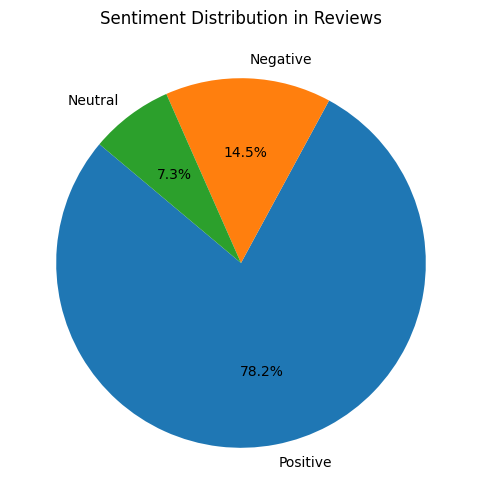

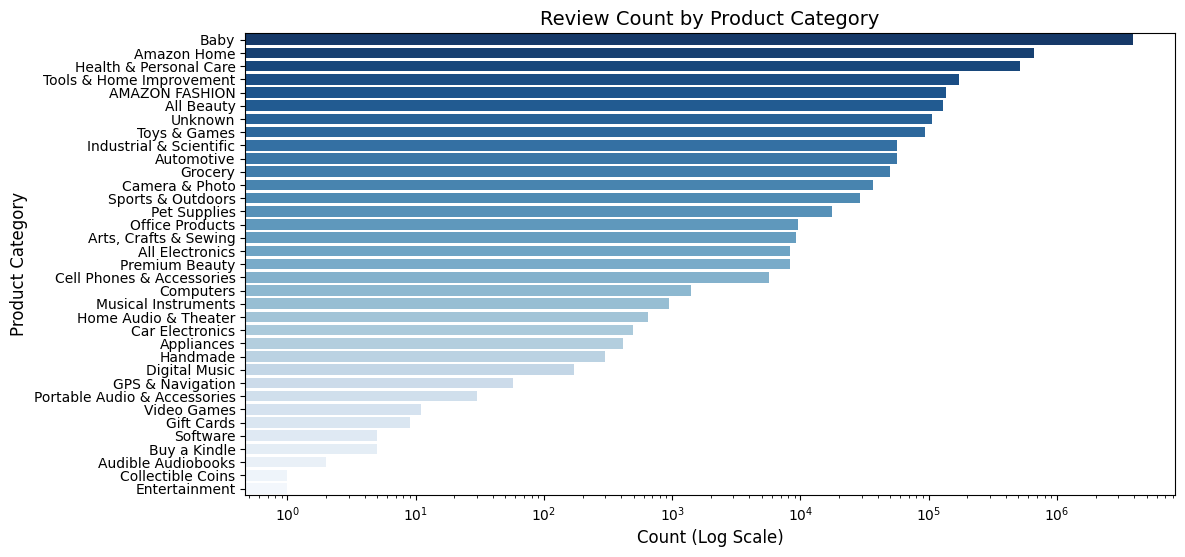

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment classification distribution
plt.figure(figsize=(6, 6))
final_df["label"].value_counts().plot.pie(autopct="%1.1f%%", startangle=140)
plt.title("Sentiment Distribution in Reviews")
plt.ylabel("")
plt.show()

# Product Category Distribution
plt.figure(figsize=(12, 6))
category_counts = final_df["main_category"].value_counts()
sns.barplot(y=category_counts.index, x=category_counts.values, hue=category_counts.index, dodge=False, palette="Blues_r", legend=False)
plt.xscale("log")
plt.title("Review Count by Product Category", fontsize=14)
plt.xlabel("Count (Log Scale)", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.show()

In [3]:
import os
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import warnings

warnings.simplefilter("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n Using device: {device}")

# Load and preprocess data
df = pd.read_csv("/content/final_cleaned_data.csv", usecols=["text", "label"])
label_map = {"Positive": 2, "Neutral": 1, "Negative": 0}
df["label"] = df["label"].map(label_map).astype(int)

# Sample and split data
df_sampled = df.sample(n=50000, random_state=42)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sampled["text"].tolist(), df_sampled["label"].tolist(), test_size=0.2, random_state=42
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_dict({"input_ids": train_encodings["input_ids"],
                                   "attention_mask": train_encodings["attention_mask"],
                                   "labels": train_labels})

test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"],
                                  "attention_mask": test_encodings["attention_mask"],
                                  "labels": test_labels})

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,  # 2e-5 → 1e-5
    per_device_train_batch_size=32,  # 16 → 32
    per_device_eval_batch_size=32,
    num_train_epochs=2,  # 3 → 2
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

# Evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

os.environ["WANDB_DISABLED"] = "true"

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train
print("\n Training Started")
trainer.train()
print("\n Training Completed")


 Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Training Started


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.291600,0.262085,0.898000,0.894810
2,0.228200,0.266031,0.901700,0.896979



 Training Completed


In [4]:
results = trainer.evaluate()
formatted_results = {
    "Loss": round(results["eval_loss"], 4),
    "Accuracy": round(results["eval_accuracy"], 4),
    "F1 Score": round(results["eval_f1"], 4),
}

# Print Final Result
import pandas as pd
df_results = pd.DataFrame(list(formatted_results.items()), columns=["Metric", "Value"])
display(df_results)

,Metric,Value
0,Loss,0.2660
1,Accuracy,0.9017
2,F1 Score,0.8970


In [5]:
test_results = trainer.predict(test_dataset)
predictions = torch.argmax(torch.tensor(test_results.predictions), dim=1)

# Some prediction results
for i in range(10):
    print(f"Actual Label: {test_labels[i]}, Prediction: {predictions[i].item()}")


Actual Label: 2, Prediction: 2
Actual Label: 2, Prediction: 2
Actual Label: 0, Prediction: 0
Actual Label: 2, Prediction: 0
Actual Label: 2, Prediction: 2
Actual Label: 0, Prediction: 0
Actual Label: 2, Prediction: 2
Actual Label: 2, Prediction: 2
Actual Label: 2, Prediction: 2
Actual Label: 2, Prediction: 2
